## MLTI Fall 2024 Final: Coding and Analysis Portion

### Instructions

Follow all instructions for each question *exactly* as written. Any deviation from the given instructions, and especially those that require me to edit any of your code in order to get it to run (including setup or data importation) will result in a loss of points.

1. Answer all questions in the assigned cells below. You must answer *only* in the assigned cells, which provide a single cell for each question, unless otherwise specified. If you need to use multiple cells to figure out how to answer a question, do so in a separate "testing" notebook, and then copy over your completed, final answer into the assigned single cell in this notebook. **Triple check that it actually runs in the final notebook**.

2. Do not leave *any* markdown notes/annotations/commentary anywhere in your final submission. If you want to make notes as you go, do so in your "testing" notebook, not in this notebook. The only markdown that should appear in your final submission is that already provided in the original version of this notebook.

3. Update all libraries you will use **prior to starting to answer questions**. Do this in a new cell in a notebook, using the command "pip install --upgrade library_name". **Delete that cell after you have upgraded your libraries**. If you are having library upgrade issues, contact me asap. You will lose points if library installation code is left in your submitted notebook.

4. Submit this completed .ipynb file to the Final submission page on Canvas. I will be running your notebook to ensure it executes correctly. **Prior to submission, do the following:**

    a) Restart your kernel and clear the output, then re-run your script to make sure it all executes correctly.
    
    b) Restart your kernel and clear the output a second time, then re-run your script to make sure it all executes correctly.
    
    c) Completely shutdown Jupyter, start it back up again, open this notebook, restart your kernel and clear output, then re-run your script to make sure it all executes correctly. There will be no excuses for code that does not run due to library incompatibilities or because you did not properly check everything runs on a new instance prior to submission.
    
    d) Restart your kernel and clear the output, and **then** submit your notebook. Do not submit a notebook in which the output is displayed.
    

**Grading:** This portion of the Final is worth 60 points, and accounts for 60% of your Final Exam grade (15% of your total course grade)

**Due Date:** 5pm, 17th December, 2024. Due to the impending grade submission deadline following this due date, any late submission will receive a score of 0.

### Background

As in the final assignment of the semester, you are a disinformation analyst who has become increasingly concerned with the use of generative AI in politically-motivated influence operations. This concern prompted you to start developing capabilities that you hope will allow you to a) detect artificially generated text being used in such operation, and b) quickly analyze the thematic content from what you predict will be an explosion of artificially-generated political text online in the near future. In that assignment, you decided to start experimenting on the first problem using simple BERT classifiers, and the second problem using latent dirichlet allocation (LDA) topic modeling.

Since then, however, you have started to wonder -- could you also use some of the simpler modelling approaches you've previously used in this course to help answer those questions?

In this final, you will explore the detection question by applying k-nearest neighbors classification and k-means clustering on the embeddings of the same headlines data that you used in that previous assignment, and explore the content question by applying named-entity recognition on the headlines.  

As a reminder, the data is a small subset of a combination of real and artificially-generated political news headlines that I myself collected/generated, as part of a real project of this nature. This time, the data has been combined into a single file, *headlines_data.csv*, with class labels included; 0 for real political news headlines, and 1 for artificially generated headlines, generated using the ChatGPT API. There are 500 headlines of each class in the data, and all headlines are 10 words long.

### Setup
Start by importing any libraries you need for this final in the cell below. You **must** import all libraries in the cell below only. Do not import any libraries anywhere else in your notebook. As a reminder, your submitted notebook should not including *any* library installation code.

In [ ]:
#Import libraries here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, ConfusionMatrixDisplay
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_lg")

Now, load in the the *headlines_data.csv* file in the cell below as a dataframe called *headlines_data*. The file you load in **must** be called headlines_data.csv and **must** be placed in the same folder as you are running this notebook. **Do not** use any customized file paths unique to your computer. If I have to adjust your code to get the data to load, you will lose poitns. Do any further inspection of the dataframe you wish to conduct in the same cell.

In [ ]:
#Import data here
headlines_data = pd.read_csv("/content/headlines_data.csv")
print("\nDataset Overview:\n", headlines_data.head())
print("\nData Summary:\n", headlines_data.info())


Dataset Overview:
                                             Headline  Class
0  Biden Says U.S. Forces Would Defend Taiwan If ...      0
1  Biden Says Queen's Death Left 'Giant Hole' For...      0
2  Democrats Nominate Seth Magaziner In Key Rhode...      0
3  US, Trump Team Propose Names For Arbiter In Ma...      0
4  Politician's DNA Connected To Las Vegas Journa...      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  1000 non-null   object
 1   Class     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB

Data Summary:
 None


### Question 1: Preparing the Embeddings for KNN and K-Means Modeling (25 points)
In order to apply any KNN or K-means models to the headlines data, you need to first obtain the word embeddings for each headline and correctly format them for modeling. Before you begin this process, run the cell below which provides a function I have written for you, *pad_embeddings*, to help with the latter part of this process. The purpose of the function is explained in more detail below.

In [ ]:
#Run this cell, do not alter it in any way
def pad_embeddings(headline_embeddings):
    padded_embeddings = np.pad(headline_embeddings, ((0, 10 - len(headline_embeddings)), (0,0)),
                               mode = "constant")
    padded_embeddings_flattened = padded_embeddings.flatten()
    return padded_embeddings_flattened

Now, prepare the embeddings for the headlines by following the process in the exact order specified below:

a) Using the NLTK library, tokenize and pre-process the headlines in the data as follows:

    i)   Convert all the words in the headlines to lower case
    ii)  Tokenize the headlines
    iii) Lemmatize the tokens
    iv)  Remove any tokens that are stopwords, using the english-language nltk.corpus stopwords module
    v)   Remove any tokens that are punctuation (e.g. periods) using the .isalnum() method
    
b) Get the Word2Vec embeddings for each of the headlines. **Important:** You MUST first get embeddings for the *entire vocabulary* (i.e. run Word2Vec on all unique tokens) in the dataset before calculating the embeddings for each individual headline. Do not generate embeddings for the headlines using separate, independent vocabularies for only those tokens present in each individual headline. Use a minimum count of 1 and a vector size of 20, and use defaults for all other arguments.

*Hint:* If you have done this correctly, the dictionary of embeddings you use to then calculate the embeddings for each headline should contain embeddings for 2,591 tokens, each of which is an array of length 20 (which we specified as the vector size)

c) Due to the pre-processing of the tokens you undertook in part a) (i.e. the removal of stop words and punctuation), you will now have differing numbers of word embeddings for different headlines, as you have variation in the number of tokens that remain for each headline following the pre-processing stage (each headline has between 5 and 10 tokens).

These differences in embeddings dimensions mean you cannot run any KNN or K-means models until the dimensions have been standardized. To do so, apply the *pad_embeddings* function to each of your headlines embeddings you obtained in part b). This function "pads" the embeddings with zeros for any headlines that have less than 10 word embeddings, ensuring all headlines now have 10 word embeddings of length 20. It then flattens the embeddings into a 2D-array so that they can be used to train the models.

Add the padded embeddings for each headline to the headlines_data dataframe in a column called "Padded_Embeddings", then display the first 5 and last 5 observations of the dataframe. The padded embeddings are what you will use for model training and testing.


In [ ]:
#Provide your answer to Question 1 in this cell
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_headline(headline):
    headline = headline.lower()
    headline_tokens = word_tokenize(headline)
    headline_tokens = [lemmatizer.lemmatize(token) for token in headline_tokens]
    headline_tokens = [token for token in headline_tokens if token not in stop_words]
    headline_tokens = [token for token in headline_tokens if token.isalnum()]
    return headline_tokens


headlines_data["processed_tokens"] = headlines_data["Headline"].apply(preprocess_headline)
model = Word2Vec(sentences=headlines_data['processed_tokens'].tolist(),
                vector_size=20,
                min_count=1)


print(f"Vocabulary size: {len(model.wv.key_to_index)}")
def get_headline_embeddings(tokens):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    return np.array(embeddings)


headlines_data["embeddings"] = headlines_data["processed_tokens"].apply(get_headline_embeddings)
headlines_data["Padded_Embeddings"] = headlines_data["embeddings"].apply(pad_embeddings)


print("\nFirst 5 rows:")
print(headlines_data[["Headline", "Class", "Padded_Embeddings"]].head())
print("\nLast 5 rows:")
print(headlines_data[["Headline", "Class", "Padded_Embeddings"]].tail())

Vocabulary size: 2591

First 5 rows:
                                            Headline  Class  \
0  Biden Says U.S. Forces Would Defend Taiwan If ...      0   
1  Biden Says Queen's Death Left 'Giant Hole' For...      0   
2  Democrats Nominate Seth Magaziner In Key Rhode...      0   
3  US, Trump Team Propose Names For Arbiter In Ma...      0   
4  Politician's DNA Connected To Las Vegas Journa...      0   

                                   Padded_Embeddings  
0  [0.04340234, -0.037096396, -0.04205424, 0.0017...  
1  [0.04340234, -0.037096396, -0.04205424, 0.0017...  
2  [0.040750653, -0.03362513, 0.032329816, -0.044...  
3  [-0.046045743, 0.017497642, 0.02942811, -0.029...  
4  [0.020949505, 0.04427107, -0.016762521, -0.037...  

Last 5 rows:
                                              Headline  Class  \
995  Brazil faces major environmental crisis, annou...      1   
996  South Korea announces new space exploration po...      1   
997  Yemen faces major health crisis, announc

### Question 2: Classification with K-Nearest Neighbors (20 points)
You are now ready to start training some models. Run two sets of K-nearest neighbors (KNN) classification models as follows:

a) Using the train_test_split function, split the headlines data into 80% training data, and 20% evaluation data. Then split the evaluation data into validation and testing data such that your final data split is 80% training, 10% validation, and 10% testing. Stratify on the class label when you do this so that your classes are equally balanced. Use a random state of 182 for all splits.
     
b) Run a set of KNN models with values of k ranging from 2 to 8 (inclusive), using Euclidian distance as the distance metric.
     
c) Run a second set of KNN models with values of k ranging from 2 to 8 (inclusive), using Manhattan distance as the distance metric.
     
d) Now, plot the prediction performance metrics for both sets of models on the validation data on the same line plot using matplotlib as follows:
         i) Plot separate lines for the acccuracy, F1-score for the positive class, recall for the positive class, and precision for the positive class for all the Euclidian distance models against the different values of k. All lines must be a shade of blue, and use different line types (e.g. solid, dashed etc) for ease of comparison.
         ii) Repeat part d)i) for all the Manhattan distance models. All lines must be a shade of red, and use the same line type for each metric type as the Euclidian distance lines (e.g. if you used a dashed line for accuracy for Euclidian distance, the accuracy line for Manhattan distance must also be dashed).
         
Make sure your plot is approrpriately labelled and titled, and includes a legend detailing what each of the 8 lines on the plot corresponds to.
         
e) Finally, choose your best performing model across all 14 models you trained and evaluated, and test in on the test data set. Display the confusion matrix for model performance using the scikit-learn metric module's ConfusionMatrixDisplay function. Then, display the model's performance metrics using the scikit-learn metric module's classification_report function.
     
Note: Choose your best model based on accuracy score (round to two decimal places only before making the decision). If multiple models are tied, break the tie using the highest F1-score on the positive class among them (again rounded to decimal places). If there still remains a tie, use the highest recall score on the positive class (to two decimal places).


Running KNN models with Euclidean distance
k=2: Accuracy=0.81, F1-Score=0.7710843373493976, Recall=0.64, Precision=0.9696969696969697
k=3: Accuracy=0.83, F1-Score=0.8089887640449438, Recall=0.72, Precision=0.9230769230769231
k=4: Accuracy=0.79, F1-Score=0.7341772151898734, Recall=0.58, Precision=1.0
k=5: Accuracy=0.8, F1-Score=0.7560975609756098, Recall=0.62, Precision=0.96875
k=6: Accuracy=0.8, F1-Score=0.75, Recall=0.6, Precision=1.0
k=7: Accuracy=0.82, F1-Score=0.7857142857142857, Recall=0.66, Precision=0.9705882352941176
k=8: Accuracy=0.79, F1-Score=0.7341772151898734, Recall=0.58, Precision=1.0

Running KNN models with Manhattan distance
k=2: Accuracy=0.91, F1-Score=0.9010989010989011, Recall=0.82, Precision=1.0
k=3: Accuracy=0.9, F1-Score=0.8936170212765957, Recall=0.84, Precision=0.9545454545454546
k=4: Accuracy=0.86, F1-Score=0.8372093023255814, Recall=0.72, Precision=1.0
k=5: Accuracy=0.88, F1-Score=0.8723404255319149, Recall=0.82, Precision=0.9318181818181818
k=6: Accuracy=0

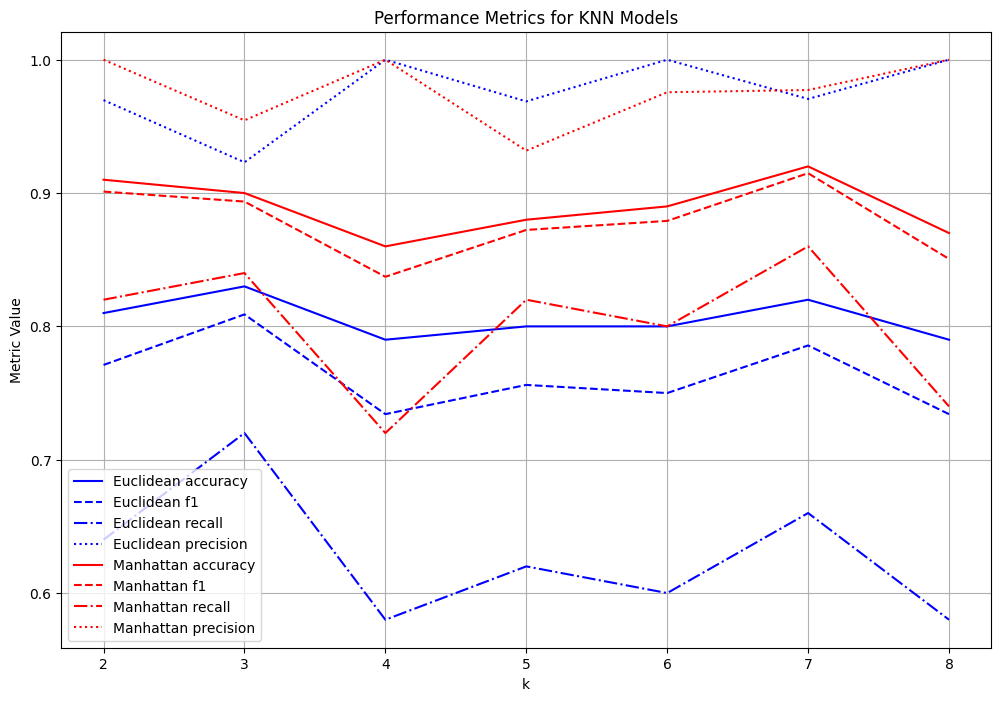


Best Model: {'k': 7, 'accuracy': 0.92, 'f1': 0.9148936170212766, 'recall': 0.86, 'precision': 0.9772727272727273}


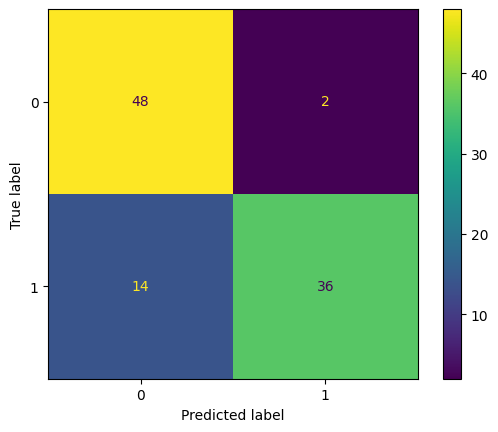


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



In [ ]:
#Provide your answer to Question 2 in this cell

X = np.stack(headlines_data['Padded_Embeddings'].values)
y = headlines_data['Class']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y,random_state=182)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=0.5, stratify=y_eval, random_state=182)
print("\nRunning KNN models with Euclidean distance")
results_euclidean = []
for k in range(2, 9):
    knn_euclidean = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn_euclidean.fit(X_train, y_train)
    y_val_pred_euclidean = knn_euclidean.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred_euclidean)
    f1 = f1_score(y_val, y_val_pred_euclidean, pos_label=1)
    recall = recall_score(y_val, y_val_pred_euclidean, pos_label=1)
    precision = precision_score(y_val, y_val_pred_euclidean, pos_label=1)
    results_euclidean.append({"k": k, "accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision})
    print(f"k={k}: Accuracy={accuracy}, F1-Score={f1}, Recall={recall}, Precision={precision}")

print("\nRunning KNN models with Manhattan distance")
results_manhattan = []
for k in range(2, 9):
    knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    knn_manhattan.fit(X_train, y_train)
    y_val_pred_manhattan = knn_manhattan.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred_manhattan)
    f1 = f1_score(y_val, y_val_pred_manhattan, pos_label=1)
    recall = recall_score(y_val, y_val_pred_manhattan, pos_label=1)
    precision = precision_score(y_val, y_val_pred_manhattan, pos_label=1)
    results_manhattan.append({"k": k, "accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision})
    print(f"k={k}: Accuracy={accuracy}, F1-Score={f1}, Recall={recall}, Precision={precision}")


plt.figure(figsize=(12, 8))
for metric, line_style in zip(["accuracy", "f1", "recall", "precision"], ["-", "--", "-.", ":"]):
    plt.plot([r["k"] for r in results_euclidean], [r[metric] for r in results_euclidean], label=f"Euclidean {metric}", linestyle=line_style, color="blue")
for metric, line_style in zip(["accuracy", "f1", "recall", "precision"], ["-", "--", "-.", ":"]):
    plt.plot([r["k"] for r in results_manhattan], [r[metric] for r in results_manhattan], label=f"Manhattan {metric}", linestyle=line_style, color="red")

plt.title("Performance Metrics for KNN Models")
plt.xlabel("k")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.show()


all_results = results_euclidean + results_manhattan
best_model = max(all_results, key=lambda x: (round(x["accuracy"], 2), round(x["f1"], 2), round(x["recall"], 2)))
print("\nBest Model:", best_model)

if best_model in results_euclidean:
    best_knn = KNeighborsClassifier(n_neighbors=best_model["k"], metric="euclidean")
else:
    best_knn = KNeighborsClassifier(n_neighbors=best_model["k"], metric="manhattan")

best_knn.fit(X_train, y_train)
y_test_pred = best_knn.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


### Question 3: Clustering with K-Means (5 points)
You will now undertake some simple K-Means clustering to see if that might also be a useful method of distinguishing between the real and artificially generated headlines. However, because you have labelled data, you are going to "cheat" a little here, when it comes to model specification and evaluation. Run a K-means clustering model as follows:

a) Using the train_test_split function, split the headlines data into 90% training data, and 10% test data. Stratify on the class label when you do this so that your classes are equally balanced. Use a random state of 182 for all splits.

b) As you already "know" there are two classes in the labelled data, run only a K-means model on the headlines embeddings with k set to 2. Use a random state of 182 and leave all other arguments as their default.

c) Use the model you trained in part b) above to make predictions on the test data, and then evaluate its peformance (this is again where you'll be "cheating" by using labelled data) by first, displaying the confusion matrix using the scikit-learn metric module's ConfusionMatrixDisplay function, and second, displaying the model's performance metrics using the scikit-learn metric module's classification_report function.

How does the K-means model compare to your best KNN model from part 2? (Just think about this and consider why it might be -- you don't need to answer it here).

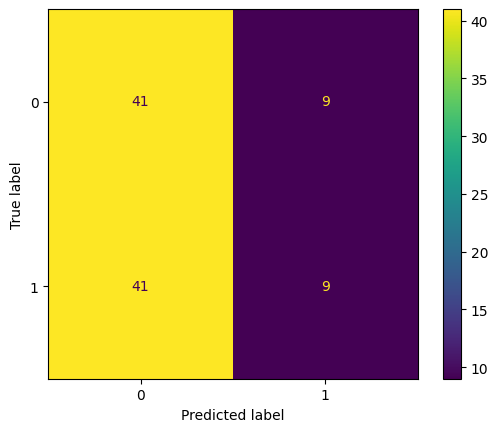


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.82      0.62        50
           1       0.50      0.18      0.26        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.44       100
weighted avg       0.50      0.50      0.44       100



In [ ]:
#Provide your answer to Question 3 in this cell
# Part A
X = np.stack(headlines_data['Padded_Embeddings'].values)
y = headlines_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=182)

# Part B
kmeans = KMeans(n_clusters=2, random_state=182)
kmeans.fit(X_train)

#Part C
y_test_pred = kmeans.predict(X_test)
from scipy.optimize import linear_sum_assignment
cm = confusion_matrix(y_test, y_test_pred)
row_ind, col_ind = linear_sum_assignment(-cm)
label_mapping = dict(zip(col_ind, row_ind))
y_test_pred = np.array([label_mapping[label] for label in y_test_pred])
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

### Question 4: Thematic "Analysis" (Exploration) Using Named Entity Recognition (10 points)
For the final question, you are going to undertake a simple named entity recognition (NER) exercise you are familiar with. As you know, NER is not going to get you a nuanced clustering of documents by topic in the same way that LDA and other topic modeling approaches might. However, if you want to get a quick look at the contents of a corpus of text data in a pinch, it can be a useful initial exploratory step. Implement NER on the *original generated headlines only* using spaCy and its en_core_web_lg pipeline as follows:

a) For every headline, identify any geopolitical entities mentioned in the headline. Do not include duplicates of the same entity if it appears multiple times in the same headline. For example, if Russia is mentioned twice in a headline it should only be "counted" once.

b) Do the same thing as in part a), but this time for Nationalities or Religious or Political Groups. Again, do not include duplicates of the same entity if it appears multiple times.

c) Now, create two bar charts next to one another (i.e. two subplots in a single plot) that i) show the top-ten most mentioned geopolitical entities in the headlines, and ii) show the top-ten most mentioned nationalities or religious or political groups in the headlines. If there are less than ten total, plot all of them. Make sure both charts are appropriately labelled (including each bar) and titled, and that the bars on the first chart are colored differently to those on the second chart. Include above each bar the total number of generated headlines in which that entity appears.

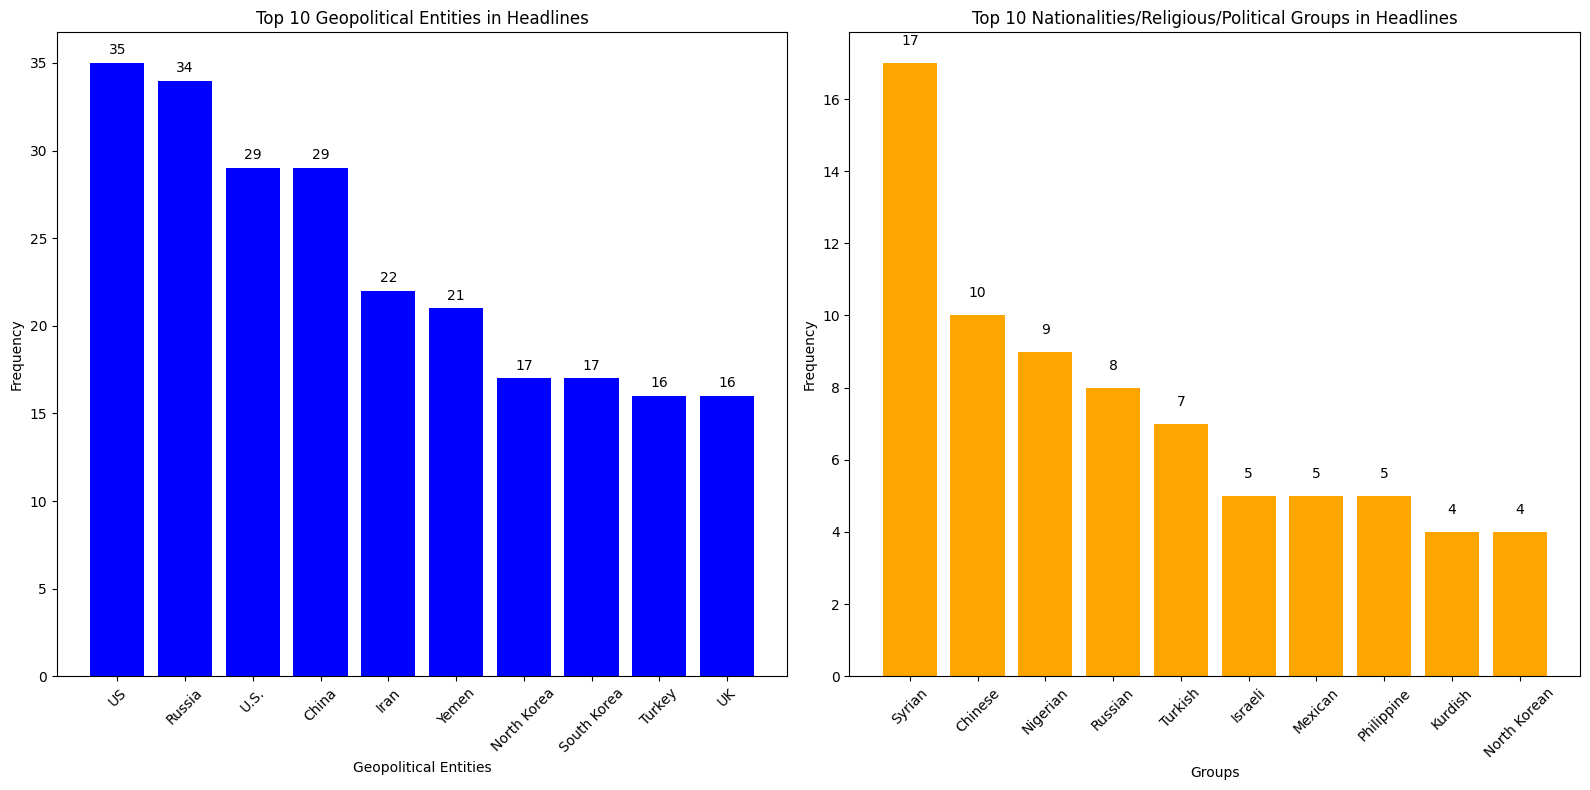

In [ ]:
#Provide your answer to Question 4 in this cell
def extract_entities(df, text_column, entity_label):
    entity_list = []
    for text in df[text_column]:
        doc = nlp(text)
        unique_entities = {ent.text for ent in doc.ents if ent.label_ == entity_label}
        entity_list.extend(unique_entities)
    return Counter(entity_list)

generated_headlines = headlines_data[headlines_data['Class'] == 1]
count_gpe = extract_entities(generated_headlines, "Headline", "GPE")
count_norp = extract_entities(generated_headlines, "Headline", "NORP")

def plot_top_entities(counts, title, xlabel, color, ax):
    top10 = counts.most_common(10)
    entities, frequencies = zip(*top10)
    ax.bar(entities, frequencies, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(frequencies):
        ax.text(i, v + 0.5, str(v), ha="center")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_top_entities(count_gpe, "Top 10 Geopolitical Entities in Headlines", "Geopolitical Entities", "blue", axes[0])
plot_top_entities(count_norp, "Top 10 Nationalities/Religious/Political Groups in Headlines", "Groups", "orange", axes[1])
plt.tight_layout()
plt.show()

### A Final Note

Congratulations on completing the semester! Thank you for all your hard work and feedback, and I wish you all the best with your future studies and career. I also hope you might someday find yourself using some of what you've learned throughout the course in the real world. Please stay in touch!

**END**